# Conceptual Functional Equivalent (CFE) Model
This model is designed to be a simplified (conceptual) model of the National Water Model, which is functionally equivalent. This is an example run of the Python implimentation of the model.
## bmi_cfe
This is the code for the Basic Model Interface (BMI) that is used to call the cfe and interact with other models via the Framework, or driving code. This code contains all the required BMI functions to run the CFE, including 
 - initialize: Perform startup tasks for the model.
 - update: Advance model state by one time step. Calls the function `run_cfe` from `cfe.py`
 - update_until: Advance model state until the given time.
 - finalize: Perform tear-down tasks for the model.
 - get_value: Get a copy of values of a given variable.
 - set_value: Set the values of a given variable.
 - etc.  
 These functions need to be called by a framework or driving code, an example of which is below.

In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import bmi_cfe

### Create an instance of the model with a specific configuration that corresponds to a particular catchmenmt.

In [2]:
cfe_instance = bmi_cfe.BMI_CFE()

### This initialization function should perform all tasks that are to take place before entering the model’s time loop. Models should be refactored, if necessary, to read their inputs (which could include filenames for other input files) from a configuration file. BMI does not impose any constraint on how configuration files are formatted.

In [3]:
cfe_instance.initialize('./cat_58_config_cfe.json')

### Open the forcing file contained within the configuration file. We can run the model with any forcing. This is only an example. The path to the forcing file is contained within the configuration file, but it doesn't really need to be. This is just for organization.

In [4]:
with open(cfe_instance.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)

### We will want to visualize the model output

In [5]:
outputs=cfe_instance.get_output_var_names()
output_lists = {output:[] for output in outputs}

### Now we loop through the forcing data and use it to run the model at each time step

In [6]:
for precip in df_forcing['APCP_surface']:
    
    cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    
    cfe_instance.update()
    
    for output in outputs:
    
        output_lists[output].append(cfe_instance.get_value(output))
        

### The finalize function should perform all tasks that take place after exiting the model’s time loop. This typically includes deallocating memory, closing files and printing reports.

In [7]:
cfe_instance.finalize(print_mass_balance=True)


GLOBAL MASS BALANCE
  initial volume:   0.5956
    volume input: 259.2000
   volume output: 248.2436
    final volume:   0.8880
        residual: 8.3489e-14

SCHAAKE MASS BALANCE
  surface runoff: 258.9076
    infiltration:   0.2924
schaake residual: 3.0087e-14

GIUH MASS BALANCE
  vol. into giuh: 258.9076
   vol. out giuh: 248.2436
 vol. end giuh q:  10.6640
   giuh residual: 7.1054e-14

SOIL WATER CONCEPTUAL RESERVOIR MASS BALANCE
   init soil vol:   0.5856
  vol. into soil:   0.2924
vol.soil2latflow:   0.0000
 vol. soil to gw:   0.0000
 final vol. soil:   0.8780
vol. soil resid.: 1.1102e-16

NASH CASCADE CONCEPTUAL RESERVOIR MASS BALANCE
    vol. to nash:   0.0000
  vol. from nash:   0.0000
 final vol. nash:   0.0000
nash casc resid.: 0.0000e+00

GROUNDWATER CONCEPTUAL RESERVOIR MASS BALANCE
init gw. storage:   0.0100
       vol to gw:   0.0000
     vol from gw:   0.0000
final gw.storage:   0.0100
    gw. residual: 0.0000e+00


### Here we are just plotting the fluxes.

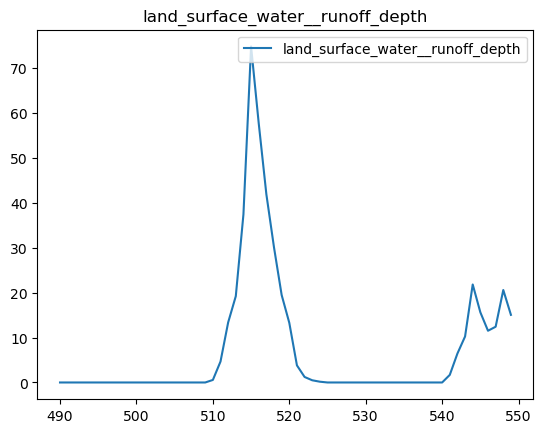

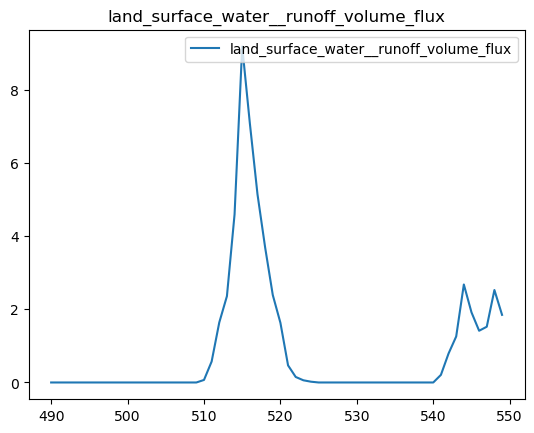

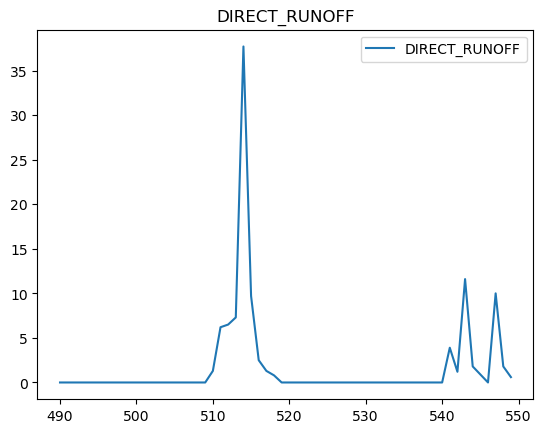

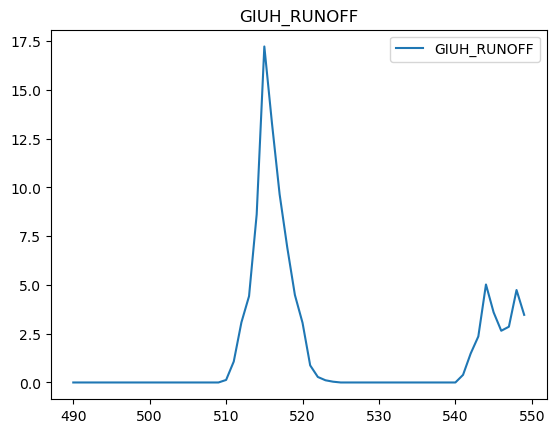

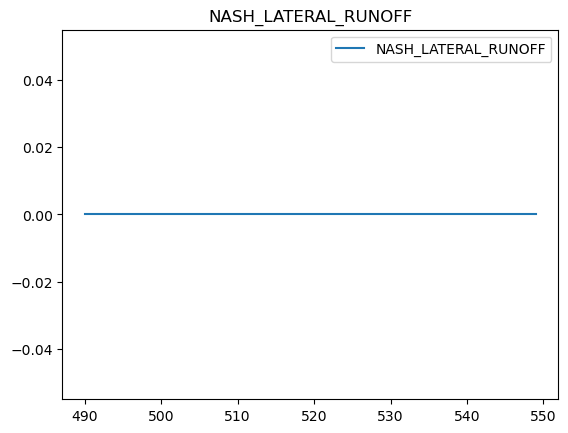

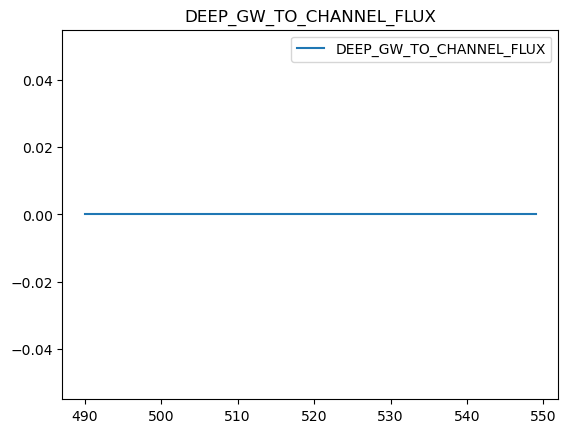

In [8]:
istart_plot=490
iend_plot=550
x = list(range(istart_plot, iend_plot))
for output in outputs:
    plt.plot(x, output_lists[output][istart_plot:iend_plot], label=output)
    plt.title(output)
    plt.legend()
    plt.show()
    plt.close()

### Here we are just going to run the unit test that compares with the origional author code. Kind of the same thing done above, but there is a function in the BMI code that does it all at once.

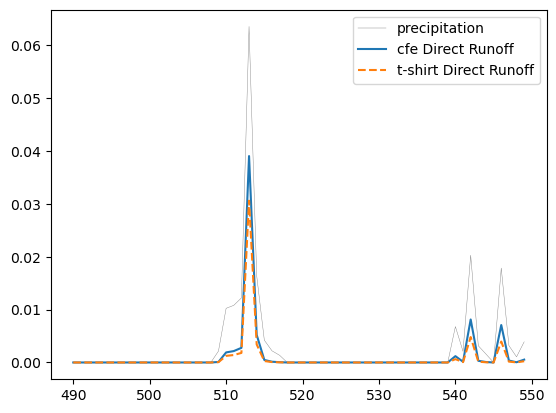

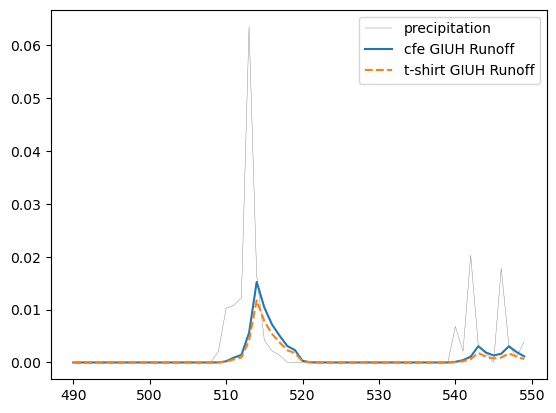

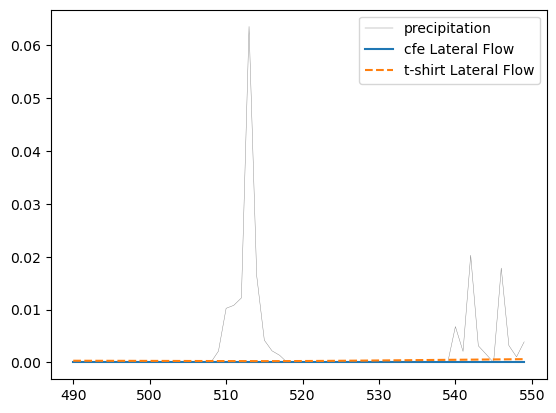

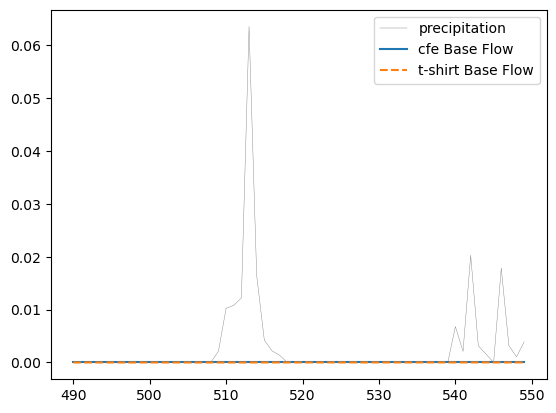

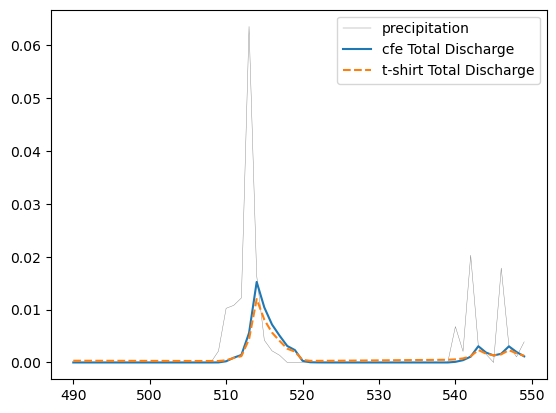

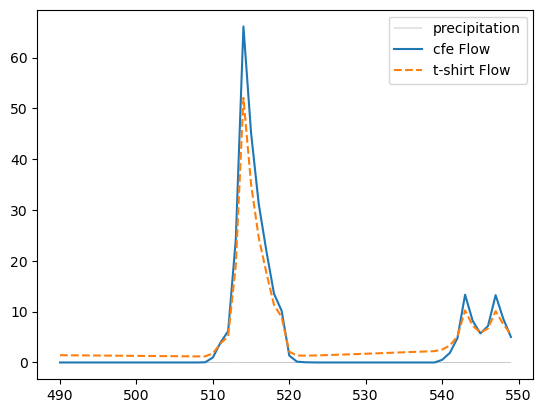

In [9]:
cfe_instance2 = bmi_cfe.BMI_CFE()
cfe_instance2.initialize('./cat_58_config_cfe.json')
cfe_instance2.run_unit_test(plot=True, print_fluxes=False)
cfe_instance2.finalize()